In [25]:
import numpy as np, pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
!pip install tqdm
from tqdm import tqdm
import torch.nn as nn

Defaulting to user installation because normal site-packages is not writeable


In [26]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [27]:
df_train = pd.read_csv("train.csv")

In [28]:
df_train.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [29]:
# Over every single 
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_train["LEN"] = df_train["POLYLINE"].apply(polyline_to_trip_duration)

In [30]:
from datetime import datetime
def parse_time(x):
    # We are using python's builtin datetime library
    # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

    # Each x is essentially a 1 row, 1 column pandas Series
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_train[["YR", "MON", "DAY", "HR", "WK"]] = df_train[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [31]:
#filter so only day type A is present
df_train = df_train[df_train['DAY_TYPE'] == 'A']

In [32]:
#One hot encoding functions
def encode_a(val):
    return int(val == 'A')

def encode_b(val):
    return int(val == 'B')

def encode_c(val):
    return int(val == 'C')

def encode_year(val):
    return int(val == 2014)

In [33]:
#Actual one hot encoding
df_train["CALL_TYPE_A"] = df_train["CALL_TYPE"].apply(encode_a)
df_train["CALL_TYPE_B"] = df_train["CALL_TYPE"].apply(encode_b)
df_train["CALL_TYPE_C"] = df_train["CALL_TYPE"].apply(encode_c)

In [34]:
#one-hot encode origin stands (min = 0, max = 63)
df_train["ORIGIN_STAND"] = df_train["ORIGIN_STAND"].fillna(0)

In [35]:
"""
call_id_times = defaultdict(list)
taxi_id_times = defaultdict(list)
origin_stand_times = defaultdict(list)
weekday_times = defaultdict(list)
month_times = defaultdict(list)
hour_times = defaultdict(list)

for i in range(len(df_train)):
    if not pd.isna(df_train.iloc[i]['ORIGIN_CALL']):
        call_id_times[int(df_train.iloc[i]['ORIGIN_CALL'])].append(df_train.iloc[i]['LEN'])
        
    taxi_id_times[df_train.iloc[i]['TAXI_ID']].append(df_train.iloc[i]['LEN'])
    
    if df_train.iloc[i]['ORIGIN_STAND'] > 0:
        origin_stand_times[df_train.iloc[i]['ORIGIN_STAND']].append(df_train.iloc[i]['LEN'])
    
    weekday_times[df_train.iloc[i]['WK']].append(df_train.iloc[i]['LEN'])
    month_times[df_train.iloc[i]['MON']].append(df_train.iloc[i]['LEN'])
    hour_times[df_train.iloc[i]['HR']].append(df_train.iloc[i]['LEN'])
    
call_id_average = defaultdict(int)
taxi_id_average = defaultdict(int)
origin_stand_average = defaultdict(int)
weekday_average = defaultdict(int)
month_average = defaultdict(int)
hour_average = defaultdict(int)

call_file = open('call_averages.txt', 'w')
for call_id in call_id_times:
    mean = sum(call_id_times[call_id]) / len(call_id_times[call_id])
    call_id_average[call_id] = mean
    call_file.write(f'{call_id} {mean}\n')
call_file.close()

taxi_file = open('taxi_averages.txt', 'w')
for taxi_id in taxi_id_times:
    mean = sum(taxi_id_times[taxi_id]) / len(taxi_id_times[taxi_id])
    taxi_id_average[taxi_id] = mean
    taxi_file.write(f'{taxi_id} {mean}\n')
taxi_file.close()
  
stand_file = open('stand_averages.txt', 'w')  
for origin_stand in origin_stand_times:
    mean = sum(origin_stand_times[origin_stand]) / len(origin_stand_times[origin_stand])
    origin_stand_average[origin_stand] = mean
    stand_file.write(f'{origin_stand} {mean}\n')
stand_file.close()
 
weekday_file = open('weekday_averages.txt', 'w')   
for weekday in weekday_times:
    mean = sum(weekday_times[weekday]) / len(weekday_times[weekday])
    weekday_average[weekday] = mean
    weekday_file.write(f'{weekday} {mean}\n')
weekday_file.close()
 
month_file = open('month_averages.txt', 'w')   
for month in month_times:
    mean = sum(month_times[month]) / len(month_times[month])
    month_average[month] = mean
    month_file.write(f'{month} {mean}\n')
month_file.close()

hour_file = open('hour_averages.txt', 'w')    
for hour in hour_times:
    mean = sum(hour_times[hour]) / len(hour_times[hour])
    hour_average[hour] = mean   
    hour_file.write(f'{hour} {mean}\n')
hour_file.close() 
"""

"\ncall_id_times = defaultdict(list)\ntaxi_id_times = defaultdict(list)\norigin_stand_times = defaultdict(list)\nweekday_times = defaultdict(list)\nmonth_times = defaultdict(list)\nhour_times = defaultdict(list)\n\nfor i in range(len(df_train)):\n    if not pd.isna(df_train.iloc[i]['ORIGIN_CALL']):\n        call_id_times[int(df_train.iloc[i]['ORIGIN_CALL'])].append(df_train.iloc[i]['LEN'])\n        \n    taxi_id_times[df_train.iloc[i]['TAXI_ID']].append(df_train.iloc[i]['LEN'])\n    \n    if df_train.iloc[i]['ORIGIN_STAND'] > 0:\n        origin_stand_times[df_train.iloc[i]['ORIGIN_STAND']].append(df_train.iloc[i]['LEN'])\n    \n    weekday_times[df_train.iloc[i]['WK']].append(df_train.iloc[i]['LEN'])\n    month_times[df_train.iloc[i]['MON']].append(df_train.iloc[i]['LEN'])\n    hour_times[df_train.iloc[i]['HR']].append(df_train.iloc[i]['LEN'])\n    \ncall_id_average = defaultdict(int)\ntaxi_id_average = defaultdict(int)\norigin_stand_average = defaultdict(int)\nweekday_average = defaul

In [55]:
df_no_call_id = df_train[pd.isna(df_train['ORIGIN_CALL'])]

times = []
for i in range(len(df_no_call_id)):
    times.append(df_no_call_id.iloc[i]['LEN'])
    
average_no_call_id_time = sum(times) / len(times)
print(average_no_call_id_time)

707.2356564380711


In [56]:
df_no_stand = df_train[df_train['ORIGIN_STAND'] == 0]

times = []
for i in range(len(df_no_stand)):
    times.append(df_no_stand.iloc[i]['LEN'])
    
average_no_stand_time = sum(times) / len(times)
print(average_no_stand_time)

763.3096668366348


In [99]:
call_id_average = defaultdict(int)
taxi_id_average = defaultdict(int)
origin_stand_average = defaultdict(int)
weekday_average = defaultdict(int)
month_average = defaultdict(int)
hour_average = defaultdict(int)

call_file = open('call_averages.txt', 'r')
line = call_file.readline().strip('\n')
while line != "":
    feature = line.split()
    call_id_average[int(feature[0])] = float(feature[1])
    line = call_file.readline().strip('\n')
call_file.close()

taxi_file = open('taxi_averages.txt', 'r')
line = taxi_file.readline().strip('\n')
while line != "":
    feature = line.split()
    taxi_id_average[int(feature[0])] = float(feature[1])
    line = taxi_file.readline().strip('\n')
taxi_file.close()

origin_file = open('stand_averages.txt', 'r')
line = origin_file.readline().strip('\n')
while line != "":
    feature = line.split()
    origin_stand_average[float(feature[0])] = float(feature[1])
    line = origin_file.readline().strip('\n')
origin_file.close()

weekday_file = open('weekday_averages.txt', 'r')
line = weekday_file.readline().strip('\n')
while line != "":
    feature = line.split()
    weekday_average[int(feature[0])] = float(feature[1])
    line = weekday_file.readline().strip('\n')
weekday_file.close()

month_file = open('month_averages.txt', 'r')
line = month_file.readline().strip('\n')
while line != "":
    feature = line.split()
    month_average[int(feature[0])] = float(feature[1])
    line = month_file.readline().strip('\n')
month_file.close()

hour_file = open('hour_averages.txt', 'r')
line = hour_file.readline().strip('\n')
while line != "":
    feature = line.split()
    hour_average[int(feature[0])] = float(feature[1])
    line = hour_file.readline().strip('\n')
hour_file.close()

In [131]:
def feature(datum):
    features = [1,
                #datum['CALL_TYPE_A'],
                #datum['CALL_TYPE_B'],
                #datum['CALL_TYPE_C'],
                #datum['ORIGIN_CALL'] if not pd.isna(datum['ORIGIN_CALL']) else 0,
                #datum['TAXI_ID'],
                #datum['ORIGIN_STAND'],
                #datum['YR'],
                #datum['MON'],
                #datum['DAY'],
                #datum['HR'],
                #datum['WK'],
                call_id_average[datum['ORIGIN_CALL']] if not pd.isna(datum['ORIGIN_CALL']) else average_no_call_id_time,
                taxi_id_average[datum['TAXI_ID']],
                origin_stand_average[datum['ORIGIN_STAND']] if datum['ORIGIN_STAND'] > 0 else average_no_stand_time,
                weekday_average[datum['WK']],
                month_average[datum['MON']],
                hour_average[datum['HR']]
               ]
    
    #origin_encoding = [0] * 64
    #origin_encoding[int(datum['ORIGIN_STAND'])] = 1
    
    #features += origin_encoding
    
    return features

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [133]:
input_size = len(feature(df_train.iloc[0]))
print(input_size)

7


In [134]:
for i in range(1):
    print(feature(df_train.iloc[i]))

[1, 707.2356564380711, 691.691610455312, 763.3096668366348, 749.7618374589038, 697.4837269980775, 594.591007858985]


In [135]:
df_sample = df_train.sample(frac=0.2)

In [136]:
features = [feature(df_sample.iloc[i]) for i in range(len(df_sample))]

In [137]:
x = torch.tensor(np.array(features), dtype = torch.float).to(device)
y = torch.tensor(np.array(df_sample["LEN"]), dtype = torch.float).to(device)

data = list(zip(x, y))
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_data, test_data, val_data = torch.utils.data.random_split(data, [train_size, test_size, val_size])

In [138]:
len(train_data), len(test_data), len(val_data)

(273707, 34214, 34213)

In [139]:
batch_size = 5
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = False)

In [140]:
learning_rate = 1e-5

In [141]:
model = nn.Sequential(
    nn.Linear(input_size, 768),
    nn.ReLU(),
    nn.Linear(768, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.ReLU()
).to(device)

In [142]:
loss_fn = torch.nn.MSELoss().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adagrad(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [143]:
from tqdm import trange
def train_epoch(train_data, model, optimizer, loss_fn, batch_size):
    losses = []
    train_len = len(train_data)

    # get a batch of training data
    for x, y in tqdm(train_data):
        # make predictions for this batch
        y_pred = torch.squeeze(model(x))
        
        # Compute the RSME loss
        loss = torch.sqrt(loss_fn(y_pred, y))
        
        # Backpropagation
        # zero out the gradients so that it will not accumulate through each iteration
        optimizer.zero_grad()
        
        # Compute the gradents with the backward call (backprop)
        loss.backward()
        
        # Update weight using gradient descent 
        optimizer.step()
        
        losses.append(loss.item())

    return np.mean(losses)

def eval_epoch(valid_loader, model, loss_function):
    total = 0
    correct = 0
    preds = []
    trues = []
    losses = []
    with torch.no_grad(): 
        for x, y in tqdm(valid_loader):
            # Compute prediction
            y_pred = torch.squeeze(model(x))
            
            loss = torch.sqrt(loss_fn(y_pred, y))
            losses.append(loss.item())
#             total += 1
#             correct += ((y <= t+10) and (y >= t-10))
#             #trues.append(t)
#             preds.append(y)
            
    return np.mean(losses)#float(correct/total*100), preds
train_losses = []
val_losses = []

In [144]:
total_epochs = 5
train_accs, valid_accs = [], []
max_acc = 0
val_loss = 0
print(f"Training on {len(train_data)} data with batch size of {batch_size}!")
for epoch in range(total_epochs):
    
    model.train() # gradient tracking is on
    
    train_loss = train_epoch(train_loader, model, optimizer, loss_fn, batch_size)
    
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = eval_epoch(valid_loader, model, loss_fn)
    val_losses.append(val_loss)
    scheduler.step()
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:>0.4f}, Validation Loss {val_loss:>0.4f}\n")

Training on 273707 data with batch size of 5!


100%|██████████| 6843/6843 [00:03<00:00, 1966.02it/s]


Epoch: 1, Train Loss: 438.8169, Validation Loss 436.7555



100%|██████████| 6843/6843 [00:03<00:00, 1788.18it/s]


Epoch: 2, Train Loss: 437.0870, Validation Loss 446.6995



100%|██████████| 6843/6843 [00:03<00:00, 1783.26it/s]


Epoch: 3, Train Loss: 436.4983, Validation Loss 448.8440



100%|██████████| 6843/6843 [00:03<00:00, 1981.49it/s]


Epoch: 4, Train Loss: 436.1080, Validation Loss 437.0973



100%|██████████| 6843/6843 [00:03<00:00, 1881.45it/s]

Epoch: 5, Train Loss: 435.8560, Validation Loss 442.2371



In [145]:
model.eval()
eval_epoch(test_loader, model, loss_fn)

100%|██████████| 6843/6843 [00:03<00:00, 1815.49it/s]


437.80215163553527

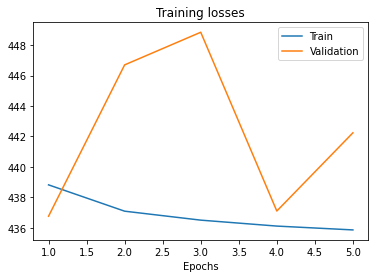

In [146]:
plt.figure()
e = len(train_losses)
x_axis = np.arange(1, e + 1, 1)
plt.plot(x_axis, train_losses, label = "Train")
plt.plot(x_axis, val_losses, label = "Validation")
plt.legend()
plt.title('Training losses')
plt.xlabel("Epochs")
plt.show()

In [147]:
torch.save(model, "MLP3")

In [148]:
df_test = pd.read_csv("test_public.csv")
df_out = df_test["TRIP_ID"].to_frame()

In [149]:
#process test data
df_test[["YR", "MON", "DAY", "HR", "WK"]] = df_test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

df_test["CALL_TYPE_A"] = df_test["CALL_TYPE"].apply(encode_a)
df_test["CALL_TYPE_B"] = df_test["CALL_TYPE"].apply(encode_b)
df_test["CALL_TYPE_C"] = df_test["CALL_TYPE"].apply(encode_c)

df_test["ORIGIN_STAND"] = df_test["ORIGIN_STAND"].fillna(0)

In [150]:
x_test = [torch.tensor(feature(df_test.iloc[i]),dtype=torch.float).to(device) for i in range(len(df_test))]

In [151]:
model.eval()
with torch.no_grad(): 
    df_out["TRAVEL_TIME"] = [float(model(x).cpu()) for x in x_test]
df_out.head()
df_out.to_csv("my_pred.csv", index=None)